In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

In [ ]:
#obtendo arquivo
url_arquivo = 'https://raw.githubusercontent.com/mf-gueiros/_sandbox/main/telecom_churn.csv'

In [ ]:
#informação das colunas
df = pd.read_csv(url_arquivo)
print(df.head())
print(df.info())

Abaixo, temos o dicionário de dados para os registros do csv fornecido:

Churn: 1 - consumidor cancelou o serviço / 0 - não cancelou 

AccountWeeks: Número de semanas que o consumidor teve uma conta ativa

ContractRenewal: 1 - consumidor renovou o contrato recentemente / 0 - não

DataPlan: 1 - consumidor tem um plano de dados / 0 - não

DataUsage: Gigabytes usados por mês

CustServCalls: Quantidade de ligações feitas para o serviço de atendimento ao cliente

DayMins: Média de minutos usados durante o dia por mês

DayCalls: Média de ligações feitas durante o dia por mês

MonthlyCharge: Valor médio da fatura mensal

OverageFee: Maior taxa de excesso incorrida nos últimos 12 meses

RoamMin: Número total de minutos que o cliente passa usando o telefone em roaming

In [ ]:
#Análise de dados faltantes
missing_data = df.isnull().sum()
print("Missing values in each column:")
print(missing_data)

Observado que não faltam dados em nenhuma das colunas.

In [ ]:
#removendo os dados binários para análise de numéricos
df_numeric = df.drop(['Churn', 'DataPlan', 'ContractRenewal'], axis=1)

#resumo dos dados numéricos
df_numeric.describe()

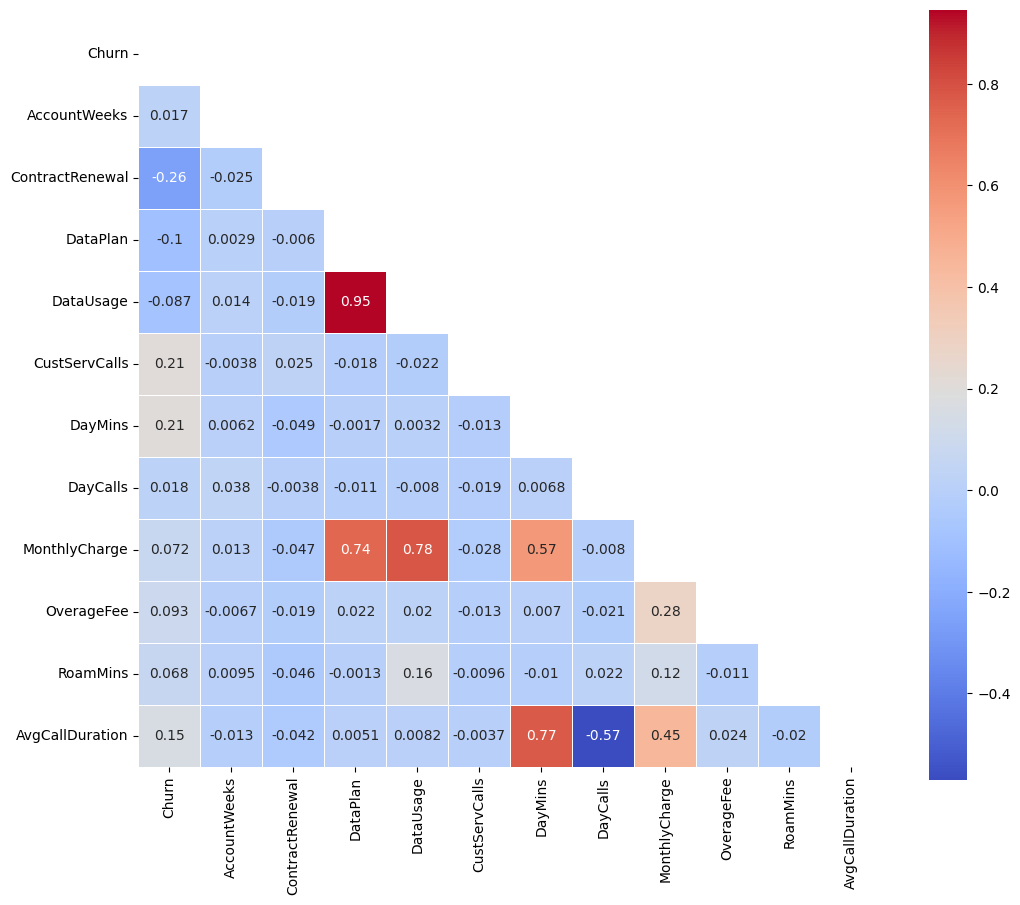

In [15]:
#matriz de correlação
corr = df.corr()

#mask para limitar o triângulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))

#tamanho do plot
plt.figure(figsize=(12, 10))

#heatmap com a mask para exibir apenas o triangulo inf
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', square=True, linewidths=0.5)

#plotando
plt.show()

Correlações:

----
                                    Churn                                        

x ContractRenewal: Apresenta correl. negativa (-0.26) -> consumidores que renovaram os contratos recentemente tendem a ter menos Churn.

x CustomerServiceCalls: Correlação positiva (0.21) -> consumidores que fazem mais ligações para o serviço tendemciam mais a cancelar o serviço

x DayMins: Correl. positiva (0.21) -> mais uso de minutos por dia indicam maior probabilidade de Churn

x MonthlyCharge: Correl. positiva (0.07) -> consumidores com maiores recargas mensais tendem a ter maior churn (todavia com relação fraca)

x OverageFee: Correl. positiva (0.09) -> maiores taxas excedentes indicam leve inclinação à ocorrência de Churn.

----


                            Inter-Campos                                       

DataPlan x DataUsage: correlação positiva forte (0,95) entre ter um plano e usar muitos dados -> faz sentido, do ponto de vista analítico, pois clientes com mais planos tendem a usar mais dados

DataUsage e MonthlyCharge: correlação positiva forte (0,78) entre o uso de dados e a cobrança mensal -> maior consumo de dados implica cobranças mensais mais altas

DayMins e DayCalls: correlação positiva moderada (0,57) entre minutos diurnos e chamadas diurnas -> sugerindo que os clientes que fazem mais chamadas também tendem a ter mais minutos

MonthlyCharge e OverageFee: correlação positiva moderada (0,28) entre cobranças mensais e taxas de excedente -> indicando que cobranças mensais mais altas podem ser parcialmente devido a taxas de excedente.

----

                            Conclusões-chave                                        

ContractRenewal e CustServCalls são recursos importantes a serem considerados para prever a rotatividade devido às suas correlações relativamente mais fortes.

DataUsage e DataPlan têm alta correlação entre sí, sugerindo redundância. Pode valer a pena considerar se ambos os recursos são necessários para o modelo ou se um pode ser derivado do outro.

Embora recursos como MonthlyCharge e OverageFee mostrem alguma correlação com a rotatividade, seus relacionamentos são fracos, sugerindo que eles podem não ser preditores fortes por si só, mas podem contribuir para um modelo preditivo em combinação com outros recursos.                          

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', data=df, palette='colorblind')
plt.title('Distribution of Churn')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

Análise

Grande parte dos clientes listados na base não deixaram a empresa/serviço (churn = 0). Esta análise sugere que é o churn é menos frequente e isso deve estar contido no treinamento do modelo

In [ ]:
# Suprimindo alertas específicos
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

# Tratando infinitos
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Setando figura do matplotlib
plt.figure(figsize=(14, 12))

# média de tempo diário por mês
plt.subplot(2, 2, 1)
sns.histplot(data=df, x='DayMins', hue='Churn', multiple='stack', palette='viridis')
plt.title('Distribution of DayMins by Churn')

# média de valor mensal
plt.subplot(2, 2, 2)
sns.histplot(data=df, x='MonthlyCharge', hue='Churn', multiple='stack', palette='viridis')
plt.title('Distribution of MonthlyCharge by Churn')

# ligações para o atendimento
plt.subplot(2, 2, 3)
sns.histplot(data=df, x='CustServCalls', hue='Churn', multiple='stack', palette='viridis')
plt.title('Distribution of CustServCalls by Churn')

# Dados mensais usados (GB)
plt.subplot(2, 2, 4)
sns.histplot(data=df, x='DataUsage', hue='Churn', multiple='stack', palette='viridis')
plt.title('Distribution of DataUsage by Churn')

plt.tight_layout()
plt.show()

**Análise da distribuição das variáveis x Churn**

DayMins X Churn: A distribuição dos minutos de uso é bastante uniforme para ambos os grupos, churned e não churned, com um pico em torno de 150 a 200 minutos. Clientes que deixaram a empresa tendem a utilizar um pouco mais os minutos diurnos, mas a diferença não é marcante. Isso sugere que o uso de minutos diurnos, por si só, não é um preditor significativo de churn, embora um uso maior possa estar associado a um risco ligeiramente maior de churn.

CustServCalls x Churn: a maioria dos clientes que permanecem na empresa (churn = 0) fez poucas chamadas (entre 1 e 2). Clientes que deixaram a empresa tendem a ter feito maior número de chamadas ao serviço de atendimento (entre 3-4 chamadas). Maior número de chamadas pode estar relacionado à insatisfação, aumentando o churn.

DataUsage x Churn: grande maioria dos clientes tem baixo volume de uso dos dados (0-1 GB). Clientes com maior uso de dados aumentam a taxa de Churn de forma leve. No entanto, por sí só este campo não é relevante na previsão do churn, sendo necessário incluir outros fatores na análise para ter maior precisão.

Distribuição de MonthlyCharge por Churn: Distribuição normal para ambos os grupos (churn ou não) com um pico em torno de 50 a 60. Clientes que deixaram a empresa tendem a ter cobranças mensais mais altas em comparação com aqueles que não deixaram. Cobranças mensais mais altas -> podem contribuir para insatisfação, aumentando a probabilidade de churn.

In [ ]:
numerical_features = ['AccountWeeks', 'DataUsage', 'CustServCalls', 'DayMins', 'DayCalls', 'MonthlyCharge', 'OverageFee']

plt.figure(figsize=(14, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data=df, x='Churn', y=feature, palette='viridis')
    plt.title(f'Box Plot of {feature} by Churn')
    plt.xlabel('Churn')
    plt.ylabel('')

plt.tight_layout()
plt.show()

**Análise dos BoxPlot**


AccountWeeks X Churn: A mediana do tempo ativo da conta é ligeiramente maior para clientes que não deixaram a empresa/serviço em comparação com aqueles que deixaram. Isso sugere que uma maior duração da conta pode estar associada a uma menor probabilidade de churn. No entanto, a dispersão geral é semelhante para ambos os grupos.

DataUsage X Churn: Clientes que não deixaram a empresa/serviço tendem a ter um uso de dados mais alto, conforme indicado pela mediana mais alta e pela faixa interquartil mais ampla. O uso de dados dos clientes que deixaram a empresa é mais baixo e mais concentrado. Isso sugere que um menor uso de dados pode ser um indicador de churn.

CustServCalls X Churn: O número de chamadas ao serviço de atendimento é notavelmente maior para clientes que deixaram a empresa/serviço, com uma mediana mais alta e um maior número de outliers. Isso sugere que um maior volume de chamadas ao serviço de atendimento está associado a uma maior probabilidade de churn, possivelmente devido à insatisfação.

DayMins X Churn: A distribuição de minutos diurnos usados por mês é semelhante para os dois grupos. No entanto, clientes que deixaram a empresa apresentam uma mediana de uso ligeiramente maior. Isso indica que o uso de minutos diurnos por si só pode não ser um forte preditor de churn.

DayCalls X Churn: A distribuição de chamadas diurnas é bastante similar entre os dois tipos de clientes, sem diferença significativa nas medianas ou na dispersão. Isso sugere que o número de chamadas diurnas não é um forte indicador de churn.

MonthlyCharge X Churn: Clientes com churn = 1 tendem a ter cobranças mensais mais altas, conforme indicado pela mediana mais alta e pela faixa interquartil mais ampla. Isso sugere que cobranças mensais mais altas podem contribuir para insatisfação e, consequentemente, para uma maior probabilidade de churn.

OverageFee X Churn: A distribuição das taxas de excesso é ligeiramente mais alta para clientes que deixaram a empresa, com uma mediana mais alta e mais outliers. Isso sugere que taxas de excesso mais altas podem estar associadas a uma maior probabilidade de churn, possivelmente devido à insatisfação dos clientes com cobranças inesperadas.


----
----
**Início da Preparação dos dados**

In [16]:
# Duração media da ligação
df['AvgCallDuration'] = df['DayMins'] / df['DayCalls']

# Replace resultados infinitos da div/0
df['AvgCallDuration'] = df['AvgCallDuration'].replace([np.inf, -np.inf], 0)

# Verificando nova construção
df.head()

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,AvgCallDuration
0,0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0,2.410000
1,0,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7,1.313821
2,0,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2,2.135088
3,0,84,0,0,0.0,2,299.4,71,57.0,3.10,6.6,4.216901
4,0,75,0,0,0.0,3,166.7,113,41.0,7.42,10.1,1.475221


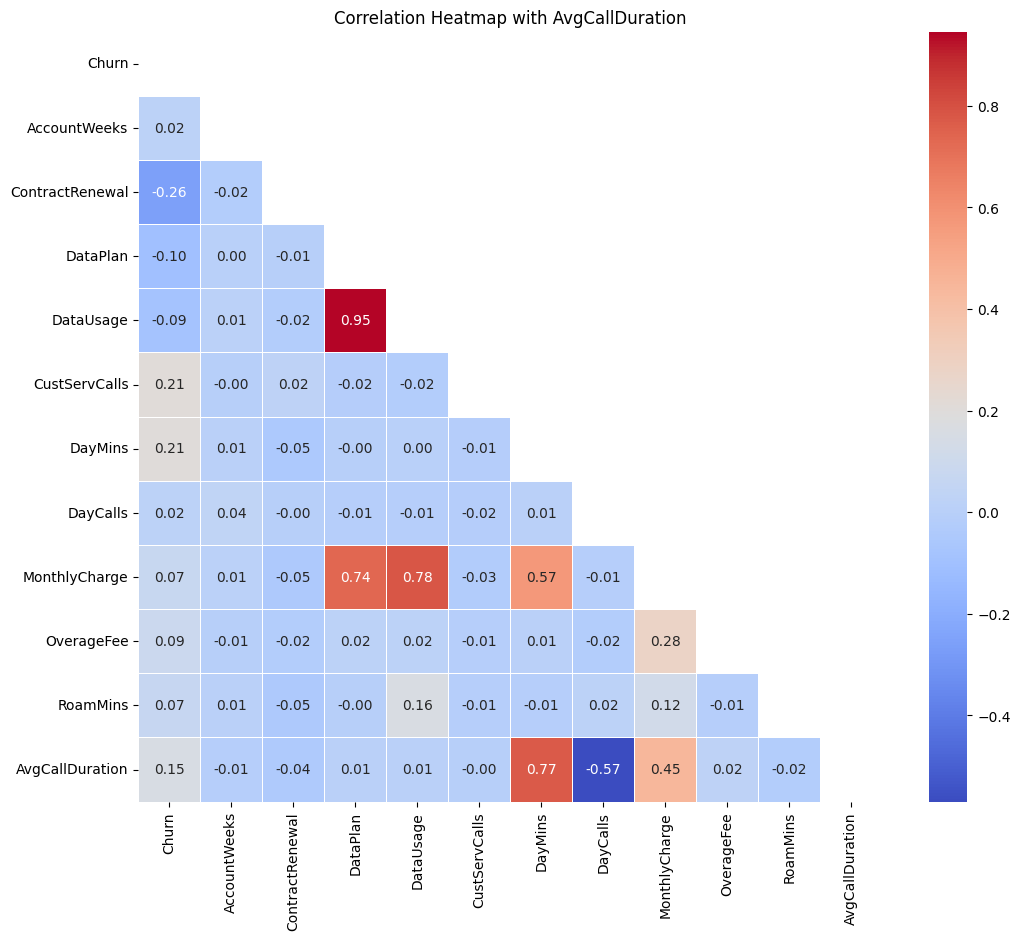

In [19]:
# Incluindo duração media da ligação no mapa de correlação
correlation_matrix = df[['Churn', 'AccountWeeks', 'ContractRenewal', 'DataPlan', 'DataUsage', 'CustServCalls', 'DayMins', 'DayCalls', 'MonthlyCharge', 'OverageFee', 'RoamMins', 'AvgCallDuration']].corr()

#mask para limitar o triângulo superior
mask2 = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plotando
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, mask=mask2, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap with AvgCallDuration')
plt.show()

Observamos uma correlação positiva fraca de 0,15 -> sugere que clientes com durações médias de chamadas mais longas podem ter uma ligeira tendência a deixarem a empresa.

----

Abaixo, são selecionadas as características para o modelo com base na análise exploratória e nas novas características derivadas. Incluímos atributos originais e novas variáveis, como a AvgCallDuration.

Decidimos incluir apenas o Plano de Dados (DataPlan) e excluir o Uso de Dados (DataUsage) devido à alta correlação entre eles (0,95). Isso evita redundância e reduz a dimensionalidade do conjunto de dados, simplificando o modelo sem perder poder preditivo.

In [20]:
# Escolhendo as colunas para o EDA
features = ['AccountWeeks', 'ContractRenewal', 'DataPlan', 'CustServCalls', 'DayMins', 'DayCalls', 'MonthlyCharge', 'OverageFee', 'RoamMins', 'AvgCallDuration']
target = 'Churn'

# Separando features de targets
X = df[features]
y = df[target]

In [25]:
# Verificando os valores NaN values no dataset
nan_counts = df[features].isnull().sum()
print("NaN values in each column of the original dataset:")
print(nan_counts)

# Lidando com os valores NaN - substituindo pela média
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Verificando se o input removeu os NaN
X_df_imputed = pd.DataFrame(X, columns=features)
nan_counts_imputed = X_df_imputed.isnull().sum()
print("NaN values in each column of the imputed dataset:")
print(nan_counts_imputed)

NaN values in each column of the original dataset:
AccountWeeks       0
ContractRenewal    0
DataPlan           0
CustServCalls      0
DayMins            0
DayCalls           0
MonthlyCharge      0
OverageFee         0
RoamMins           0
AvgCallDuration    2
dtype: int64
NaN values in each column of the imputed dataset:
AccountWeeks       0
ContractRenewal    0
DataPlan           0
CustServCalls      0
DayMins            0
DayCalls           0
MonthlyCharge      0
OverageFee         0
RoamMins           0
AvgCallDuration    0
dtype: int64


In [26]:
# Padronizando os features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertendo os dados padronizados para um DataFrame para facilitar a manipulação
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Exibindo as formas dos conjuntos resultantes
print(f'Training set shape: X={X_train.shape}, y={y_train.shape}')
print(f'Testing set shape: X={X_test.shape}, y={y_test.shape}')

Training set shape: X=(2666, 10), y=(2666,)
Testing set shape: X=(667, 10), y=(667,)


In [27]:
# Definindo o espaço dos hiperparâmetros
param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Inicializando o modelo Random Forest
rf = RandomForestClassifier(random_state=42)

# Inicializando o RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_distributions, 
    n_iter=50,  # Número de combinações aleatórias
    cv=3,  # Divisões de Validação Cruzada
    verbose=2, 
    random_state=42, 
    n_jobs=-1
)

# Realizando a busca aleatória
random_search.fit(X_train, y_train)

# Exibindo os melhores parâmetros e a melhor acurácia
print("Melhores parâmetros encontrados: ", random_search.best_params_)
print("Melhor acurácia encontrada: ", random_search.best_score_)

# Realizando previsões com o melhor modelo
best_rf = random_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Avaliando o modelo
print("Modelo Random Forest com Otimização de Hiperparâmetros")
print("Acurácia:", accuracy_score(y_test, y_pred_rf))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_rf))
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_rf))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Melhores parâmetros encontrados:  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
Melhor acurácia encontrada:  0.9354844157993764
Modelo Random Forest com Otimização de Hiperparâmetros
Acurácia: 0.9325337331334332
Matriz de Confusão:
 [[559   7]
 [ 38  63]]
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96       566
           1       0.90      0.62      0.74       101

    accuracy                           0.93       667
   macro avg       0.92      0.81      0.85       667
weighted avg       0.93      0.93      0.93       667



In [30]:
# Modelo sem otimização de parâmetros
# Inicializa o modelo Random Forest
rf_no_opt = RandomForestClassifier(random_state=42, n_estimators=100)

# Treina o modelo
rf_no_opt.fit(X_train, y_train)

# Faz previsões
y_pred_rf_no_opt = rf_no_opt.predict(X_test)

# Avalia o modelo
print("\nModelo Random Forest sem Otimização de Hiperparâmetros")
print("\nAcurácia:", accuracy_score(y_test, y_pred_rf_no_opt))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred_rf_no_opt))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_rf_no_opt))


Modelo Random Forest sem Otimização de Hiperparâmetros

Acurácia: 0.9265367316341829

Matriz de Confusão:
 [[557   9]
 [ 40  61]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.93      0.98      0.96       566
           1       0.87      0.60      0.71       101

    accuracy                           0.93       667
   macro avg       0.90      0.79      0.84       667
weighted avg       0.92      0.93      0.92       667



In [32]:
# Inicializa o modelo Gradient Boosting
gb = GradientBoostingClassifier(random_state=42, n_estimators=100)

# Treina o modelo
gb.fit(X_train, y_train)

# Faz previsões
y_pred_gb = gb.predict(X_test)

# Avalia o modelo
print("Modelo Gradient Boosting")
print("\nAcurácia:", accuracy_score(y_test, y_pred_gb))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred_gb))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_gb))


Modelo Gradient Boosting

Acurácia: 0.9325337331334332

Matriz de Confusão:
 [[557   9]
 [ 36  65]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       566
           1       0.88      0.64      0.74       101

    accuracy                           0.93       667
   macro avg       0.91      0.81      0.85       667
weighted avg       0.93      0.93      0.93       667



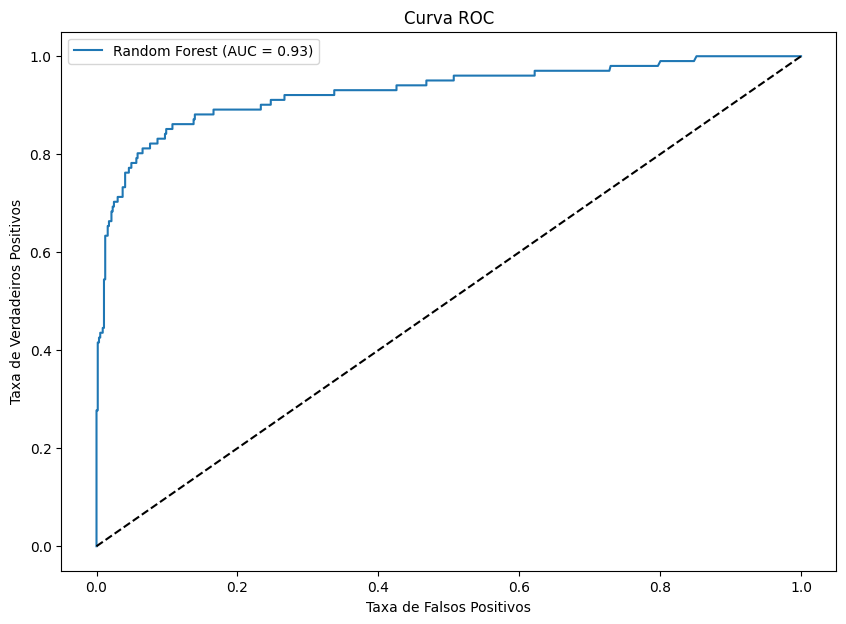

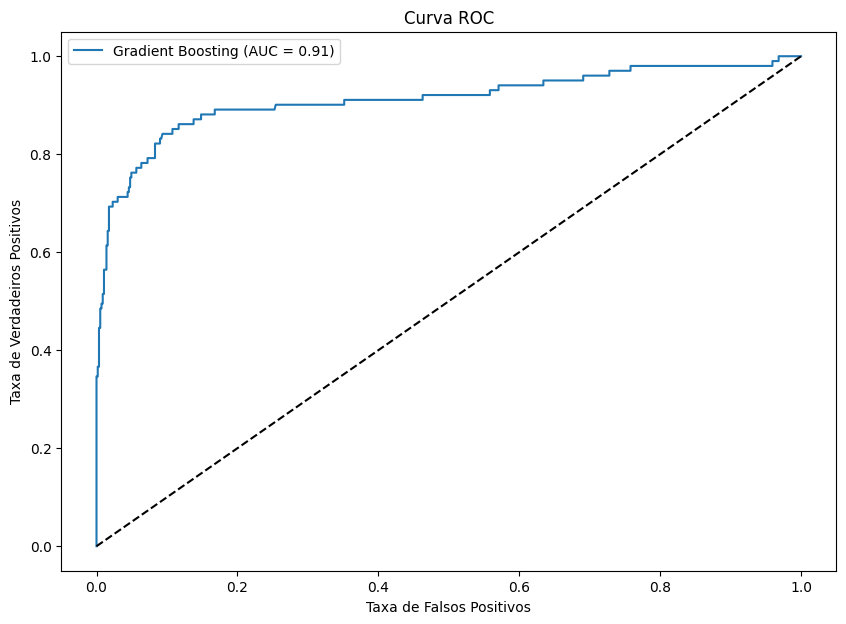

In [33]:
# Curva ROC para o Random Forest com Otimização de Hiperparâmetros
proba_best_rf = best_rf.predict_proba(X_test)[:, 1]
fpr_best_rf, tpr_best_rf, _ = roc_curve(y_test, proba_best_rf)
auc_best_rf = roc_auc_score(y_test, proba_best_rf)

plt.figure(figsize=(10, 7))
plt.plot(fpr_best_rf, tpr_best_rf, label=f'Random Forest (AUC = {auc_best_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='best')
plt.show()

# Curva ROC para o Gradient Boosting
proba_gb = gb.predict_proba(X_test)[:, 1]
fpr_gb, tpr_gb, _ = roc_curve(y_test, proba_gb)
auc_gb = roc_auc_score(y_test, proba_gb)

plt.figure(figsize=(10, 7))
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {auc_gb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='best')
plt.show()

In [34]:
# Dados de exemplo de cliente
example_customer = {
    'AccountWeeks': 12,
    'ContractRenewal': 0,
    'DataPlan': 1,
    'CustServCalls': 1,
    'DayMins': 60,
    'DayCalls': 2,
    'MonthlyCharge': 75.0,
    'OverageFee': 10.0,
    'RoamMins': 15.0,
    'AvgCallDuration': 60 / 2,  # DayMins / DayCalls
}

# Converte os dados de exemplo para um DataFrame
example_customer_df = pd.DataFrame([example_customer])

# Verifica se os nomes das features correspondem aos usados durante o treinamento do modelo
expected_features = [
    'AccountWeeks', 'ContractRenewal', 'DataPlan', 'CustServCalls',
    'DayMins', 'DayCalls', 'MonthlyCharge', 'OverageFee', 'RoamMins', 'AvgCallDuration'
]

# Reordena as colunas para corresponder à ordem esperada das features
example_customer_df = example_customer_df[expected_features]

# Pré-processa os dados de exemplo
example_customer_imputed = imputer.transform(example_customer_df)  # Imputa valores ausentes
example_customer_scaled = scaler.transform(example_customer_imputed)  # Padroniza os dados

# Faz a previsão usando o modelo Gradient Boosting
example_prediction = gb.predict(example_customer_scaled)
example_prediction_proba = gb.predict_proba(example_customer_scaled)

# Exibe a previsão
churn_prediction = 'Churn' if example_prediction[0] == 1 else 'No Churn'
churn_probability = example_prediction_proba[0][1]  # Probabilidade de churn

print(f"Previsão: {churn_prediction}")
print(f"Probabilidade de Churn: {churn_probability:.2f}")

Previsão: Churn
Probabilidade de Churn: 0.93


C:\Users\mf_gu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


In [35]:
# assumindo que 1 mês tem ~4 semanas
df['AccountMonths'] = df['AccountWeeks'] / 4
df['CustomerLifetimeValue'] = df['MonthlyCharge'] * df['AccountMonths']

# Calcula o valor médio da vida útil do cliente
average_clv = df['CustomerLifetimeValue'].mean()

print(f"O valor médio da vida útil do cliente é: ${average_clv:.2f}")

O valor médio da vida útil do cliente é: $1424.67
